# What is ElasticNet?

One of our very first more "advanced" trading strategy beyond equal-weight Buy & Hold and Monthly Rebalance strategies implements an ElasticNet to make predictions that inform future trading decisions. But what exactly is an ElasticNet? In essence, it is just linear regression combined with *regularization*.

Let $\mathbf{\mathit{X}}$ be a feature matrix of dimensions $n \times k$, where $n$ is the number of observations and $k$ the number of features. Using the weight vector $\vec{w}$ of length $k$ and the label vector $\vec{y}$ of length $n$, ordinary least squares (OLS) regression aims to find the weights $\hat{\vec{w}}$ that minimize

$$
\hat{\vec{w}} = \underset{\vec{w}}{\arg \min}\,\lVert\mathbf{\mathit{X}} \vec{w} - \vec{y}\rVert_\mathrm{L^2}^2.
$$

ElasticNet extends this by introducing a linear combination of the penalties used in **Lasso** ($\mathrm{L^1}$) and **Ridge** ($\mathrm{L^2}$) regression. The objective becomes

$$
\hat{\vec{w}} = \underset{\vec{w}}{\arg \min}\,
\lVert\mathbf{\mathit{X}} \vec{w} - \vec{y}\rVert_\mathrm{L^2}^2
+ \lambda_1 \lVert \vec{w} \rVert_\mathrm{L^1}
+ \lambda_2 \lVert \vec{w} \rVert_\mathrm{L^2}^2.
$$

In our implementation, we use `scikit-learn`’s `ElasticNet`, whose objective function reads

$$
\hat{\vec{w}} = \underset{\vec{w}}{\arg \min}\,
\dfrac{1}{2n}\lVert\mathbf{\mathit{X}} \vec{w} - \vec{y}\rVert_\mathrm{L^2}^2
+ \alpha \left( l1_\mathrm{ratio}\lVert \vec{w} \rVert_\mathrm{L^1}
+ \tfrac{1 - l1_\mathrm{ratio}}{2}\lVert \vec{w} \rVert_\mathrm{L^2}^2 \right),
$$

where $\alpha$ controls the overall strength of regularization and $l1_\mathrm{ratio}$ determines the balance between Lasso and Ridge behavior. The additional scaling constants are included for numerical stability.


## Why regularization?

To properly treat regularization would go far beyond the scope of this intuitive discussion, but there’s a simple way to motivate it.

Imagine that the label vector $\vec{y}$ is indeed linearly dependent on one or several features, but that it is also noisy. If we use a large number of features and rely only on OLS, the model will try to perfectly match every $y_i$ in $\vec{y}$, thus learning the noise rather than the underlying relationship. Such a model fits the training data perfectly but performs poorly on unseen data.

Regularization counteracts this tendency. The effect is easiest to understand visually in two dimensions. Ellipses around the OLS optimum mark sets of weights that yield the same OLS loss, while:

- Diamonds around the origin mark constant-$\mathrm{L^1}$ (Lasso) penalty levels.  
- Circles mark constant-$\mathrm{L^2}$ (Ridge) penalty levels.  
- Rounded diamonds mark constant ElasticNet penalties.

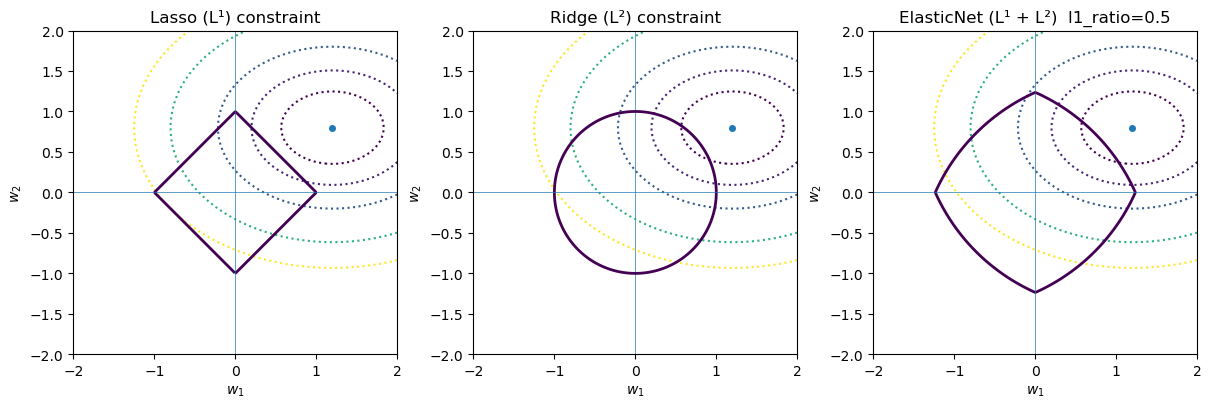

In [8]:
from mlbt.notebooks.demonstration import notebook_elasticNet_penalties
notebook_elasticNet_penalties(l1_ratio=0.5)

Where the OLS ellipses first touch one of these boundaries lies the solution $\hat{\vec{w}}$ to the regularized objective. The parameter $\alpha$ determines how strongly the penalty constrains the solution: larger $\alpha$ shrinks the feasible region toward the origin, biasing $\hat{\vec{w}}$ more heavily toward smaller weights.

In essence, regularization moves the solution away from the pure OLS optimum and biases it toward the origin. Any other point on the same OLS ellipse would have identical fit quality but larger weights, hence greater sensitivity to noise and higher variance in predictions. This trade-off is known as the **bias–variance trade-off**: we accept a small bias in exchange for lower variance and better generalization to unseen data.

## Geometric intuition to the penalties

Because of their different geometries, the penalties influence the solution in distinct ways.

The diamond-shaped Lasso penalty often intersects the OLS ellipses at a corner, where one or more coefficients are exactly zero. This induces feature selection and reduces model complexity. However, with highly correlated features, Lasso may arbitrarily select one feature and ignore others.

The circular Ridge penalty has no corners, so intersections rarely occur on the axes. Ridge smoothly shrinks all coefficients toward zero, handling multicollinearity well, but it does not perform feature selection.

The rounded-diamond ElasticNet penalty blends the two. It can zero out irrelevant features while stabilizing correlated ones, a desirable balance for noisy, correlated financial signals.

The table below gives a summarizing overview:

| Method | Penalty | Behavior | Pros | Cons |
|:-------|:---------|:----------|:------|:------|
| **Lasso** | $\mathrm{L^1}$ | Forces some coefficients exactly to zero | Produces sparse, interpretable models; automatic feature selection | Unstable when features are highly correlated (tends to pick one and ignore others) |
| **Ridge** | $\mathrm{L^2}$ | Shrinks all coefficients smoothly toward zero | Handles multicollinearity well; keeps all features | No feature selection (coefficients never exactly zero) |
| **ElasticNet** | $\mathrm{L^1 + L^2}$ | Combines sparsity with stability | Encourages group selection (correlated features can enter together); balances bias and variance | Requires tuning two hyperparameters ($\alpha$, $l1_\mathrm{ratio}$) |